# Competitors

4 November, 2024

@roman

Code to append neighbors info to dataset

In [55]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

from scipy.spatial import KDTree
import scipy.sparse as sp
from scipy import io

import statsmodels.formula.api as smf
import statsmodels.api as sm
# import lognormal
from scipy.stats import lognorm

In [2]:
# Settings
# show 100 columns in pandas
pd.set_option('display.max_columns', 100)

---
# Data

## Read all competitors

In [3]:
# directory where files are
data_dir = '../../data/tmp/'

# get files which have competitors_info_* in their name
files = [f for f in os.listdir(data_dir) if 'competitors_info_' in f]

# loook length of files
len(files)

114

In [4]:
# read each file and append to a dataframe
df_comps_info = pd.concat([pd.read_parquet(data_dir + f) for f in files], ignore_index=True)

# look
print(df_comps_info.shape)
df_comps_info.head()

(1909138, 6)


,observation_id_own,weighted_mean,weighted_std,mean,std,num_neighbors
0,00598e09-f435-47ea-a468-7ef45cdddc39,9.184653,0.245636,9.179834,0.289263,60.0
1,0077f2ba-2fa0-410d-bbc5-a11b4bee9d7a,8.963524,0.191812,8.972299,0.172118,60.0
2,0089142d-1c8d-48af-8552-96f575b1b9e8,9.236652,0.240315,9.185256,0.236103,60.0
3,00948ac3-a750-47d3-8a73-45820cdf2a1d,9.090504,0.286367,9.149526,0.271607,60.0
4,00ab3e6c-e7a9-4972-9626-e0508a58c7c9,9.194806,0.120627,9.245321,0.144446,60.0


In [5]:
# look nan values
df_comps_info.isna().sum()

observation_id_own      0
weighted_mean           0
weighted_std          655
mean                    0
std                     0
num_neighbors           0
dtype: int64

In [6]:
# get # of properties which have 1 num_neighbors
df_comps_info['num_neighbors'].le(1).sum()

655

In [7]:
# stay only with neighted_mean and weighted_std
df_comps_info = df_comps_info.loc[:, ['observation_id_own', 'weighted_mean', 'weighted_std', 'num_neighbors']]

# rename weighted_mean and weighted_std as log_ppsm_mean_comps and log_ppsm_std_comps
df_comps_info = df_comps_info.rename(columns={'weighted_mean': 'log_ppsm_mean_comps', 'weighted_std': 'log_ppsm_std_comps'})

# look
df_comps_info.head()

,observation_id_own,log_ppsm_mean_comps,log_ppsm_std_comps,num_neighbors
0,00598e09-f435-47ea-a468-7ef45cdddc39,9.184653,0.245636,60.0
1,0077f2ba-2fa0-410d-bbc5-a11b4bee9d7a,8.963524,0.191812,60.0
2,0089142d-1c8d-48af-8552-96f575b1b9e8,9.236652,0.240315,60.0
3,00948ac3-a750-47d3-8a73-45820cdf2a1d,9.090504,0.286367,60.0
4,00ab3e6c-e7a9-4972-9626-e0508a58c7c9,9.194806,0.120627,60.0


## Properties

In [8]:
# important cols
cols2keep = [
    'observation_id',
    'neighborhood',
    'state_id',
    'municipality_id',
    'city_cluster',
    'latitude',
    'longitude',
    'market_price',
    'price',
    'saleable_area',
    'built_area',
    'land_area',
    'property_class_id',
    'property_type_id',
    'age_in_months',
]

# ['half_bathrooms',
#  'full_bathrooms',
#  'property_class_more_common_in_area',
#  'neighborhood',
#  'constructor',
#  'zip_code',
#  'age_in_months',
#  'parking_lots',
#  'valuation_date',
#  'potable_water_service_id',
#  'lighting_service_id',
#  'sidewalk_id',
#  'project_quality_id',
#  'property_class_id',
#  'conservation_status_id',
#  'controller_id',
#  'elevator_service_id',
#  'state_id',
#  'equipment_id',
#  'curb_id',
#  'infrastructure_service_id',
#  'road_materials_id',
#  'municipality_id',
#  'grantor_id',
#  'urban_proximity_id',
#  'water_collection_service_id',
#  'electrical_supply_service_id',
#  'telephone_service_supply_id',
#  'property_type_id',
#  'public_transportation_service_id',
#  'valuation_unit_id',
#  'valuation_professional_id',
#  'latitude',
#  'longitude',
#  'level',
#  'total_levels',
#  'purpose_of_appraisal',
#  'bedrooms',
#  'built_area',
#  'saleable_area',
#  'land_area',
#  'rentable_units',
#  'rentable_units_subject_property',
#  'current_use',
#  'market_price',
#  'price',
#  'built_price',
#  'land_price',
#  'access_routes',
#  'remaining_useful_life',
#  'observation_id',
#  'property_id',
#  'city_cluster',
#  'geometry']

In [9]:
# read properties
gdf_properties = pd.read_parquet("../../data/interim/cleaned_data_s4.parquet")

# stay only with important cols
gdf_properties = gdf_properties.loc[:, cols2keep]

# get price per sqm
gdf_properties['ppsm'] = gdf_properties['price'] / gdf_properties['saleable_area']

# to geopandas
gdf_properties = gpd.GeoDataFrame(
    gdf_properties,
    geometry=gpd.points_from_xy(gdf_properties['longitude'], gdf_properties['latitude']),
    crs="EPSG:4326"
    )

# change crs to 6372
gdf_properties = gdf_properties.to_crs("EPSG:6372")

# look
print(gdf_properties.shape)
gdf_properties.head()

(1909959, 17)


,observation_id,neighborhood,state_id,municipality_id,city_cluster,latitude,longitude,market_price,price,saleable_area,built_area,land_area,property_class_id,property_type_id,age_in_months,ppsm,geometry
0,43c375b2-75fd-4fcc-b311-55b396e7cbbf,MAYA,31,050,0,21.014297,-89.575189,2348706.0,2349000.0,154.929993,141.550003,198.000000,4,2,204,15161.686639,POINT (3784284.380 1056168.461)
1,f95c14fe-9acc-4b5c-872b-bd15d412a65d,MULCHECHEN,31,041,0,20.916897,-89.580945,424468.0,424000.0,54.209999,52.049999,133.750000,3,2,192,7821.435292,POINT (3784619.353 1045421.310)
2,185761da-dc39-4835-86c5-981424f72208,LOCALIDAD DE CHABLEKAL,31,050,0,21.097061,-89.618003,17284861.0,17285000.0,674.960022,520.500000,1200.000000,5,2,120,25608.924140,POINT (3779083.399 1064873.781)
3,4e2c4e1a-e759-48ab-a4f6-2d1dbc6f55da,FRACCIONAMIENTO AMANECERES,31,041,0,20.961569,-89.529486,1183300.0,1183000.0,111.629997,111.629997,181.699997,3,2,0,10597.509891,POINT (3789501.256 1050788.609)
4,d51a3c97-180f-453a-8364-800116e0bfd6,MERIDA,31,050,0,21.015836,-89.654367,1878072.0,1878000.0,138.380005,103.570000,364.000000,4,2,240,13571.324857,POINT (3776105.913 1055630.688)


## Merge

In [10]:
# merge with df_comps_info
gdf_properties = (
    gdf_properties
    .merge(
        df_comps_info,
        how='inner',
        left_on='observation_id',
        right_on='observation_id_own'
    )
    .drop(columns='observation_id_own')
)

# see size
print(gdf_properties.shape)

# see if any observation_id is duplicated
print(gdf_properties['observation_id'].duplicated().sum())

(1909138, 20)
0


---
# EDA

## S1: General EDA for $\mu$ and $\sigma$ and $n$

### Num comps

In [11]:
# distribution of num_neighbors
gdf_properties['num_neighbors'].describe()

count    1.909138e+06
mean     5.938698e+01
std      4.777671e+00
min      1.000000e+00
25%      6.000000e+01
50%      6.000000e+01
75%      6.000000e+01
max      6.000000e+01
Name: num_neighbors, dtype: float64

In [12]:
# how many props have less than n neighbors
n_neighbors = [2, 5, 10, 30, 50, 60]

# get the number of properties which have less than n_neighbors grouped by class
pd.concat(
    [(
        gdf_properties
        .groupby('property_type_id', as_index=False)
        .apply(lambda x: x['num_neighbors'].lt(n).mean(), include_groups=False)
        .assign(n_neighbors=n)
        .rename(columns={None: 'prop_less_than_n_neighbors'})
    ) for n in n_neighbors
    ],
).pivot(index='property_type_id', columns='n_neighbors', values='prop_less_than_n_neighbors')

n_neighbors,2,5,10,30,50,60
property_type_id,,,,,,
2,0.000292,0.001009,0.002082,0.007096,0.012851,0.016181
3,0.000206,0.000555,0.001094,0.003853,0.007647,0.010472
4,0.000633,0.002576,0.005781,0.022336,0.041005,0.050875


### General EDA for $\mu$

count    1.909138e+06
mean     9.480905e+00
std      4.564730e-01
min      0.000000e+00
25%      9.204248e+00
50%      9.391772e+00
75%      9.655984e+00
max      1.242689e+01
Name: log_ppsm_mean_comps, dtype: float64


/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='log_ppsm_mean_comps', ylabel='Density'>

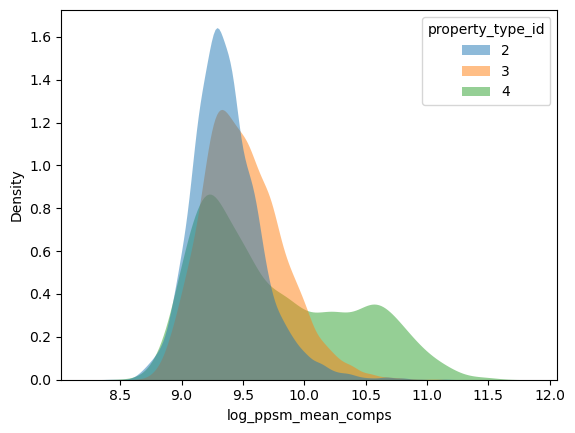

In [13]:
# distribution of log_ppsm_mean_comps
print(gdf_properties['log_ppsm_mean_comps'].describe())

# kde of log_ppsm_mean_comps
sns.kdeplot(
    data=(
        gdf_properties
        .query("num_neighbors > 1")
        .groupby('property_type_id', as_index=False)
        .sample(10_000)
    ),
    x='log_ppsm_mean_comps',
    hue='property_type_id',
    common_norm=False,
    fill=True,
    alpha=.5,
    linewidth=0,
    palette='tab10'
)

In [14]:
# see how many std are close to cero
(
    gdf_properties
    .query("num_neighbors > 1")
    .groupby('property_type_id')
    ['log_ppsm_mean_comps']
    .apply(lambda x: x.le(1).sum())   
    )

property_type_id
2    0
3    0
4    1
Name: log_ppsm_mean_comps, dtype: int64

<Axes: xlabel='num_neighbors', ylabel='log_ppsm_mean_comps'>

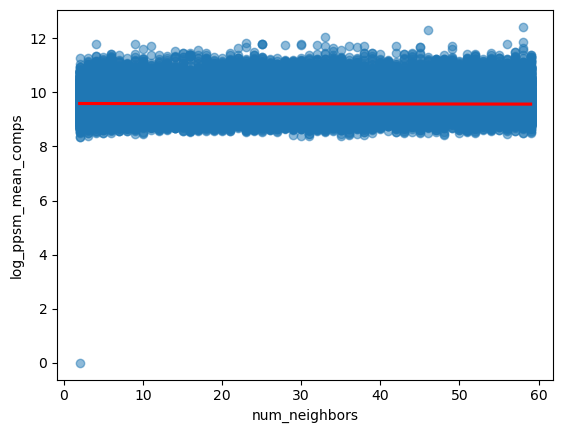

In [15]:
# relationship between mu & num_neighbors
sns.regplot(
    data=(
        gdf_properties
        .query("num_neighbors.between(2, 59)")
    ),
    x='num_neighbors',
    y='log_ppsm_mean_comps',
    scatter_kws={'alpha': .5},
    line_kws={'color': 'red'}
)

### General EDA for $\sigma$

count    1.908483e+06
mean     1.142407e-01
std      7.785962e-02
min      0.000000e+00
25%      5.263483e-02
50%      1.005210e-01
75%      1.605004e-01
max      1.257892e+00
Name: log_ppsm_std_comps, dtype: float64


/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='log_ppsm_std_comps', ylabel='Density'>

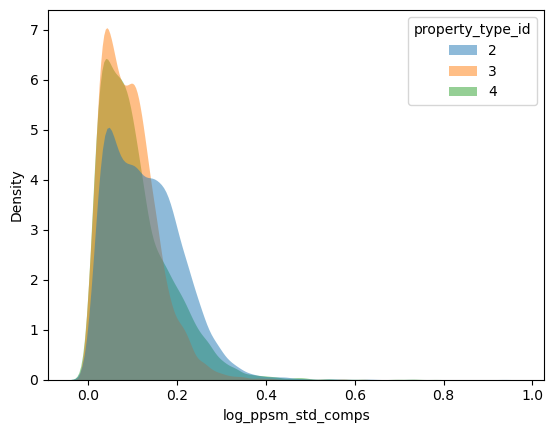

In [16]:
# distribution of log_ppsm_std_comps
print(gdf_properties['log_ppsm_std_comps'].describe())

# kde of log_ppsm_std_comps
sns.kdeplot(
    data=(
        gdf_properties
        .query("num_neighbors > 1")
        .groupby('property_type_id', as_index=False)
        .sample(10_000)
    ),
    x='log_ppsm_std_comps',
    hue='property_type_id',
    common_norm=False,
    fill=True,
    alpha=.5,
    linewidth=0,
    palette='tab10'
)

In [17]:
# see how many std are close to cero
(
    gdf_properties
    .query("num_neighbors > 1")
    .groupby('property_type_id')
    ['log_ppsm_std_comps']
    .apply(lambda x: x.le(0).sum())   
    )

property_type_id
2    1199
3    1054
4     473
Name: log_ppsm_std_comps, dtype: int64

^^^
important to see whcih properties have std close to cero and why


<Axes: xlabel='num_neighbors', ylabel='log_ppsm_std_comps'>

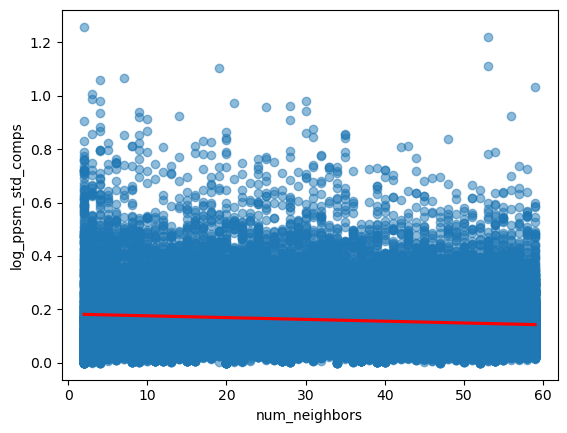

In [18]:
# relationship between sigma & num_neighbors
sns.regplot(
    data=(
        gdf_properties
        .query("num_neighbors.between(2, 59)")
    ),
    x='num_neighbors',
    y='log_ppsm_std_comps',
    scatter_kws={'alpha': .5},
    line_kws={'color': 'red'}
)

^^^
it looks that the bigger the $n$ the smaller the $\sigma$

<Axes: xlabel='log_ppsm_mean_comps', ylabel='log_ppsm_std_comps'>

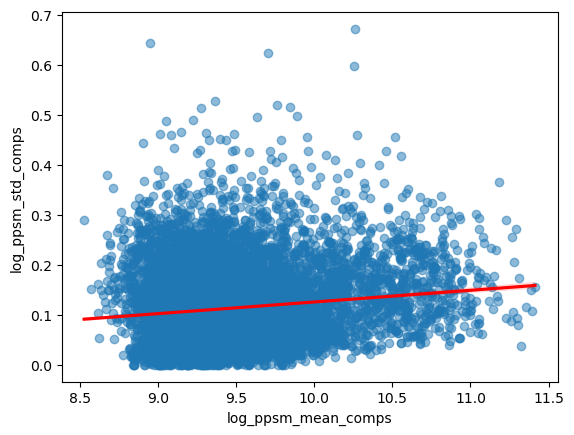

In [19]:
# relationship between mu & sigma
sns.regplot(
    data=(
        gdf_properties
        .query("num_neighbors > 1")
        .sample(10_000)
    ),
    x='log_ppsm_mean_comps',
    y='log_ppsm_std_comps',
    scatter_kws={'alpha': .5},
    line_kws={'color': 'red'}
)

## S2: Error

### Best stat for MAPE

In [20]:
# get mean, median, and mode of lognormal
gdf_properties = (
    gdf_properties
    # stats
    .assign(
        mean_comps_ppsm=lambda x: np.exp(x['log_ppsm_mean_comps'] + x['log_ppsm_std_comps']**2 / 2),
        median_comps_ppsm=lambda x: np.exp(x['log_ppsm_mean_comps']),
        mode_comps_ppsm=lambda x: np.exp(x['log_ppsm_mean_comps'] - x['log_ppsm_std_comps']**2)
    )
    # error
    .assign(
        mape_mean=lambda x: np.abs(x['mean_comps_ppsm'] - x['ppsm']) / x['ppsm'],
        mape_median=lambda x: np.abs(x['median_comps_ppsm'] - x['ppsm']) / x['ppsm'],
        mape_mode=lambda x: np.abs(x['mode_comps_ppsm'] - x['ppsm']) / x['ppsm']
    )
)

In [21]:
# get description of mape's
(
    gdf_properties
    .query("num_neighbors > 1")
    .groupby('property_type_id')
    [['mape_mean', 'mape_median', 'mape_mode']]
    .describe()
    .T
    .style.format("{:.2%}")
)

^^^
the mode looks like the best estimator

### Error distribution

In [22]:
# get errors
gdf_properties['perc_error_comps'] = (gdf_properties['mode_comps_ppsm'] - gdf_properties['ppsm']) / gdf_properties['ppsm']
gdf_properties['abs_perc_error_comps'] = gdf_properties['perc_error_comps'].abs()

# describe perc error by property type
(
    gdf_properties
    .query("num_neighbors > 1")
    .groupby('property_type_id')
    ['perc_error_comps']
    .describe()
)

,count,mean,std,min,25%,50%,75%,max
property_type_id,,,,,,,,
2,958391.0,-0.002465,0.155511,-0.864913,-0.073745,-0.004031,0.040605,3.578219
3,529873.0,-0.004725,0.103807,-0.830771,-0.048044,-0.001107,0.029543,2.308948
4,420219.0,-0.005084,0.119976,-0.999965,-0.052341,-0.003881,0.032421,3.140416


<Axes: xlabel='abs_perc_error_comps', ylabel='Density'>

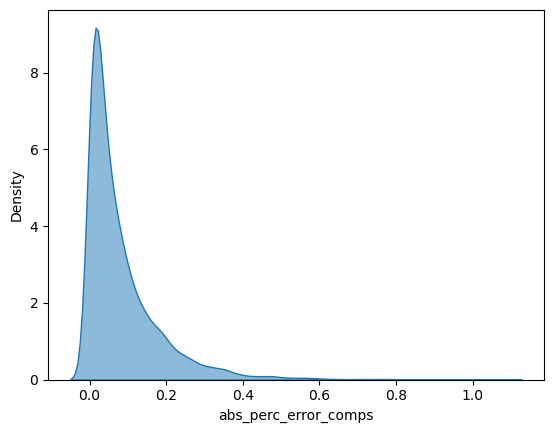

In [45]:
# kde of error
sns.kdeplot(
    data=(
        gdf_properties
        .query("num_neighbors > 1")
        .sample(10_000)
    ),
    x='abs_perc_error_comps',
    fill=True,
    alpha=.5
)

In [53]:
# general error
(
    gdf_properties
    .query("num_neighbors > 1")
    ['abs_perc_error_comps']
    .mean()
)

0.08399713836318316

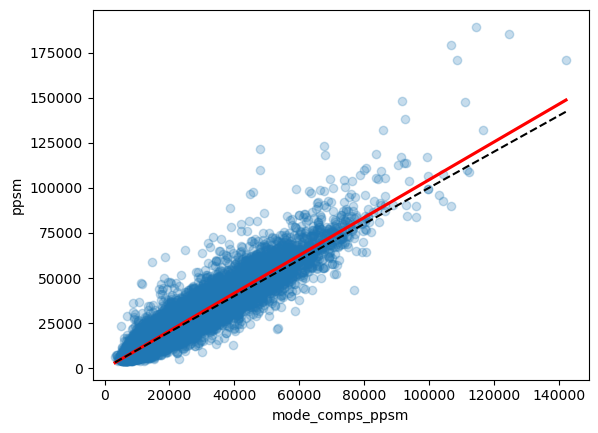

In [51]:
# correspondence between mode and ppsm
df4plot = (
    gdf_properties
    .query("num_neighbors > 1")
    .sample(100_000)
)

# plot
sns.regplot(
    data=df4plot,
    x='mode_comps_ppsm',
    y='ppsm',
    scatter_kws={'alpha': .25},
    line_kws={'color': 'red'}
)

# add 45 degree line
plt.plot([df4plot['mode_comps_ppsm'].min(), df4plot['mode_comps_ppsm'].max()], [df4plot['mode_comps_ppsm'].min(), df4plot['mode_comps_ppsm'].max()], 'k--')


In [52]:
# see corr
df4plot[['mode_comps_ppsm', 'ppsm']].corr()

,mode_comps_ppsm,ppsm
mode_comps_ppsm,1.000000,0.962014
ppsm,0.962014,1.000000


/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


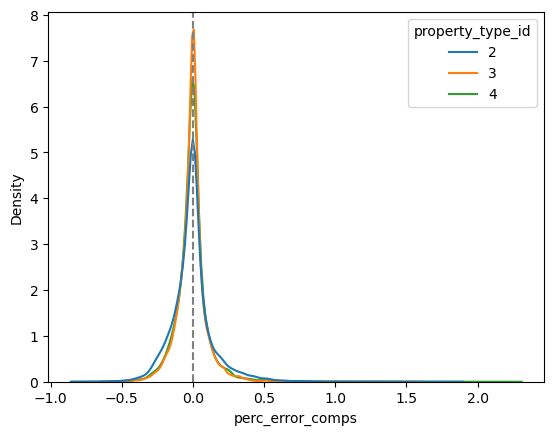

In [23]:
# kde plot of mode mape by property_type_id
sns.kdeplot(
    data=(
        gdf_properties
        .query("num_neighbors > 1")
        .groupby('property_type_id', as_index=False)
        .sample(10_000)
    ),
    x='perc_error_comps',
    hue='property_type_id',
    common_norm=False,
    palette='tab10'
)

# add vline at 0
plt.axvline(0, color='gray', linestyle='--')

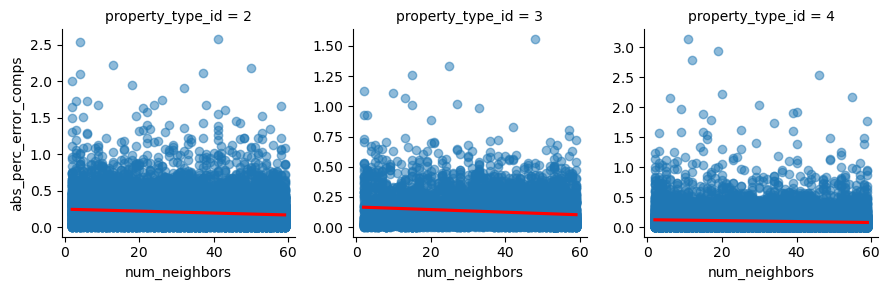

In [24]:
# see if error depends on num_neighbors
df2plot = (
    gdf_properties
    .query("num_neighbors.between(2, 59)")
)

# relationship between perc_error_comps & num_neighbors
g = sns.FacetGrid(df2plot, col='property_type_id', col_wrap=3, sharex=False, sharey=False)

g.map(sns.regplot, 'num_neighbors', 'abs_perc_error_comps', scatter_kws={'alpha': .5}, line_kws={'color': 'red'})

In [25]:
# see via lm model with lognormal distribution
model_lm_perc_error_comps = smf.ols(
    formula='abs_perc_error_comps ~ num_neighbors * C(property_type_id)',
    data=gdf_properties.query("num_neighbors.between(2, 59) & abs_perc_error_comps > 0", engine='python'),
).fit()

# see summary
model_lm_perc_error_comps.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     abs_perc_error_comps   R-squared:                       0.093
Model:                              OLS   Adj. R-squared:                  0.093
Method:                   Least Squares   F-statistic:                     859.9
Date:                  Mon, 04 Nov 2024   Prob (F-statistic):               0.00
Time:                          14:15:14   Log-Likelihood:                 17335.
No. Observations:                 41799   AIC:                        -3.466e+04
Df Residuals:                     41793   BIC:                        -3.461e+04
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  0.2469      0.003     86.896      0.000       0.241       0.252
C(property_type_id)[T.3]                  -0.0795      0.006    -13.453      0.000      -0.091      -0.068
C(property_type_id)[T.4]                  -0.1225      0.004    -32.654      0.000      -0.130      -0.115
num_neighbors                             -0.0013   7.76e-05    -17.182      0.000      -0.001      -0.001
num_neighbors:C(property_type_id)[T.3]     0.0002      0.000      1.621      0.105   -5.17e-05       0.001
num_neighbors:C(property_type_id)[T.4]     0.0006      0.000      5.399      0.000       0.000       0.001
==============================================================================
Omnibus:                    33763.624   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1530272.921
Skew:                           3.569   Prob(JB):                         0.00
Kurtosis:                      31.770   Cond. No.                         345.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ravj/opt/anaconda3/envs/mds-rese

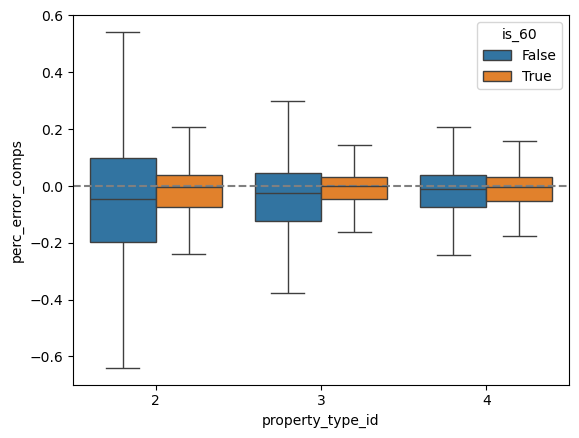

In [26]:
# see if errors distribute the same before 59 and 60 neighbors
df4plot = (
    gdf_properties
    .query("num_neighbors.between(2, 60)")
    .assign(is_60=lambda x: x['num_neighbors'].ge(60))
    .groupby(['property_type_id', 'is_60'])
    .sample(5_000)
)

# boxplot of perc_error_comps by property_type_id and hue is_60 with no outliers
sns.boxplot(data=df4plot, x='property_type_id', y='perc_error_comps', hue='is_60', showfliers=False)

# add hline at 0
plt.axhline(0, color='gray', linestyle='--')


/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ravj/opt/anaconda3/envs/mds-rese

<Axes: xlabel='property_type_id', ylabel='abs_perc_error_comps'>

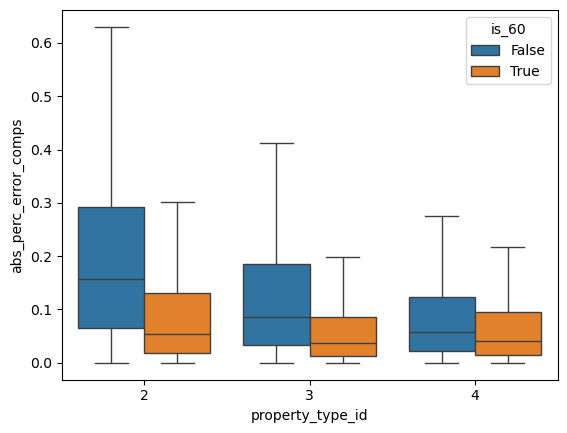

In [27]:
# see if errors distribute the same before 59 and 60 neighbors
df4plot = (
    gdf_properties
    .query("num_neighbors.between(2, 60)")
    .assign(is_60=lambda x: x['num_neighbors'].ge(60))
    .groupby(['property_type_id', 'is_60'])
    .sample(5_000)
)

# boxplot of perc_error_comps by property_type_id and hue is_60 with no outliers
sns.boxplot(data=df4plot, x='property_type_id', y='abs_perc_error_comps', hue='is_60', showfliers=False)


### Error distribution by geography

In [28]:
# error distribution by state
(
    gdf_properties
    .query("num_neighbors > 1")
    .groupby('state_id')
    ['abs_perc_error_comps']
    .describe()
    .style.format("{:.2%}")
)

,count,mean,std,min,25%,50%,75%,max
state_id,,,,,,,,
01,4676300.00%,7.56%,9.96%,0.00%,1.54%,4.08%,9.97%,195.39%
02,2850600.00%,8.83%,11.02%,0.00%,1.89%,5.08%,11.96%,218.10%
03,1563100.00%,9.63%,11.80%,0.00%,2.23%,5.84%,12.83%,292.99%
04,753800.00%,12.72%,12.07%,0.00%,3.78%,9.53%,18.07%,162.01%
05,9582400.00%,8.75%,10.57%,0.00%,1.77%,5.16%,11.96%,221.98%
06,2173700.00%,8.58%,9.91%,0.00%,1.95%,5.26%,11.82%,129.24%
07,1785900.00%,10.27%,12.05%,0.00%,2.22%,6.04%,14.22%,174.09%
08,10409600.00%,9.57%,10.87%,0.00%,2.23%,6.13%,13.05%,173.48%
09,10824200.00%,12.61%,13.30%,0.00%,3.85%,8.90%,17.13%,314.04%


<Axes: xlabel='abs_perc_error_comps', ylabel='Count'>

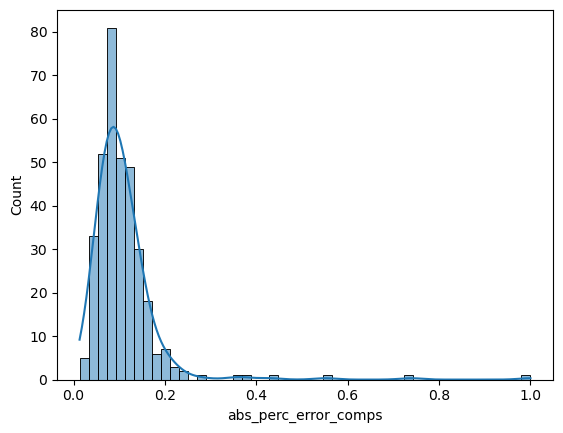

In [29]:
# error distribution by municipality
err_mun = (
    gdf_properties
    .query("num_neighbors > 1")
    .groupby(['state_id', 'municipality_id'])
    ['abs_perc_error_comps']
    .mean()
)

# histogram of error by municipality
sns.histplot(err_mun, bins=50, kde=True)

In [30]:
# error distribution by state
df_aux = (
    gdf_properties
    .query("num_neighbors > 1")
    .groupby('city_cluster')
    ['abs_perc_error_comps']
    .describe()
    .sort_values(by='mean', ascending=False)
)

# see head & tail
pd.concat([df_aux.head(), df_aux.tail()])

,count,mean,std,min,25%,50%,75%,max
city_cluster,,,,,,,,
109,1568.0,0.145402,0.135503,3.882055e-05,0.039842,0.107662,0.208921,0.853886
89,2720.0,0.136616,0.129369,5.817809e-06,0.041328,0.100510,0.193794,1.084204
12,9746.0,0.131681,0.134832,2.818735e-06,0.031314,0.094598,0.187812,1.526465
3,4940.0,0.131495,0.121103,7.082308e-06,0.040171,0.101708,0.185840,1.620086
53,3795.0,0.127924,0.123821,2.080935e-04,0.039090,0.093961,0.178755,1.671839
8,24183.0,0.043605,0.068184,1.763747e-16,0.006279,0.021019,0.052283,1.738616
52,14551.0,0.038485,0.049903,2.665882e-16,0.006339,0.019401,0.051614,0.631573
105,1380.0,0.032715,0.052950,1.288092e-15,0.007335,0.018052,0.034038,0.551267
65,7050.0,0.031712,0.047668,7.184869e-07,0.006350,0.016948,0.036363,1.300656


^^^ some places have a lot of error on its comps

### Error distribution by sigma

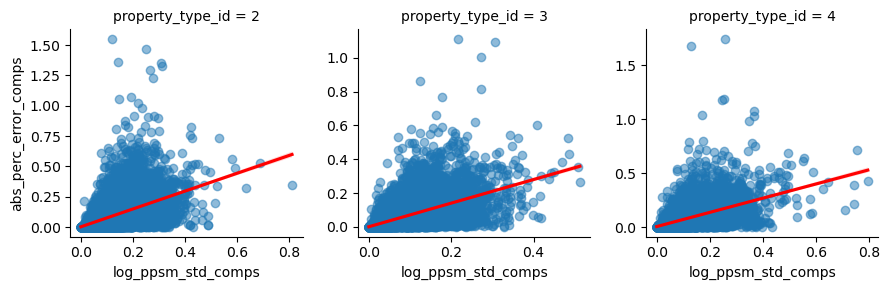

In [31]:
# subset
df4plot = (
    gdf_properties
    .query("num_neighbors > 1")
    .groupby(['property_type_id'])
    .sample(10_000)
)

# plot relationship between perc_error_comps & log_ppsm_std_comps
g = sns.FacetGrid(df4plot, col='property_type_id', col_wrap=3, sharex=False, sharey=False)

g.map(sns.regplot, 'log_ppsm_std_comps', 'abs_perc_error_comps', scatter_kws={'alpha': .5}, line_kws={'color': 'red'})

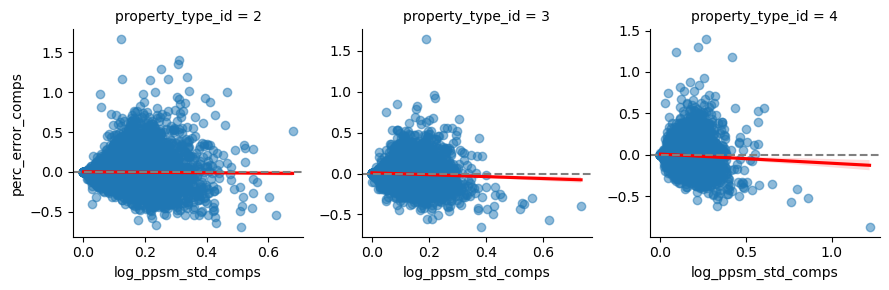

In [32]:
# subset
df4plot = (
    gdf_properties
    .query("num_neighbors > 1")
    .groupby(['property_type_id'])
    .sample(10_000)
)

# plot relationship between perc_error_comps & log_ppsm_std_comps
g = sns.FacetGrid(df4plot, col='property_type_id', col_wrap=3, sharex=False, sharey=False)

g.map(sns.regplot, 'log_ppsm_std_comps', 'perc_error_comps', scatter_kws={'alpha': .5}, line_kws={'color': 'red'})

# h line at 0
for ax in g.axes:
    ax.axhline(0, color='gray', linestyle='--')

### Error distribution by characteristics

In [33]:
# distribution of abs error by property_type_id
(
    gdf_properties
    .query("num_neighbors > 1")
    .groupby('property_type_id')
    ['abs_perc_error_comps']
    .describe()
)

,count,mean,std,min,25%,50%,75%,max
property_type_id,,,,,,,,
2,958391.0,0.098613,0.120271,0.000000e+00,0.019449,0.057634,0.135569,3.578219
3,529873.0,0.065961,0.080296,0.000000e+00,0.013600,0.038386,0.089150,2.308948
4,420219.0,0.073405,0.095036,1.266071e-16,0.016034,0.041940,0.095679,3.140416


/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


<Axes: xlabel='property_type_id', ylabel='abs_perc_error_comps'>

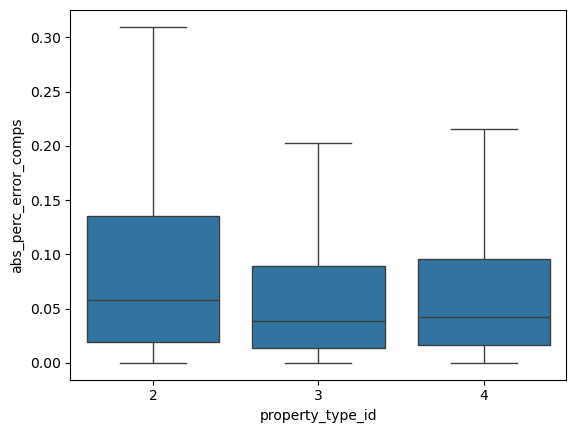

In [34]:
# plot boxplot of abs_perc_error_comps by property_type_id
sns.boxplot(data=gdf_properties.query("num_neighbors > 1"), x='property_type_id', y='abs_perc_error_comps', showfliers=False)

/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


<Axes: xlabel='property_class_id', ylabel='abs_perc_error_comps'>

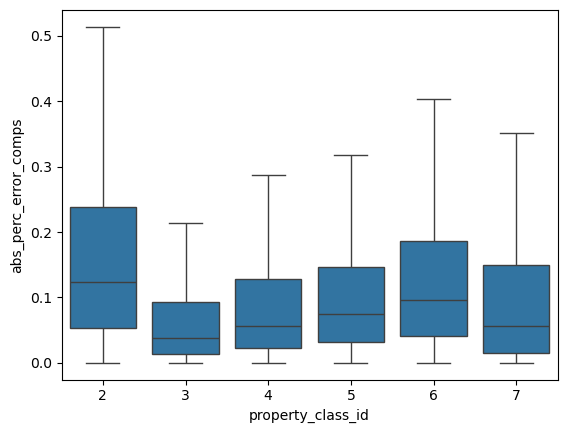

In [35]:
# plot boxplot of abs_perc_error_comps by property_class_id
sns.boxplot(data=gdf_properties.query("num_neighbors > 1"), x='property_class_id', y='abs_perc_error_comps', showfliers=False)

In [36]:
# plot boxplot of abs_perc_error_comps by age_in_months
model_lm_perc_error_comps = smf.ols(
    formula='abs_perc_error_comps ~ age_in_months',
    data=gdf_properties.query("num_neighbors > 1", engine='python'),
).fit()

# see summary
model_lm_perc_error_comps.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     abs_perc_error_comps   R-squared:                       0.085
Model:                              OLS   Adj. R-squared:                  0.085
Method:                   Least Squares   F-statistic:                 1.774e+05
Date:                  Mon, 04 Nov 2024   Prob (F-statistic):               0.00
Time:                          14:15:36   Log-Likelihood:             1.6576e+06
No. Observations:               1908483   AIC:                        -3.315e+06
Df Residuals:                   1908481   BIC:                        -3.315e+06
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0617   9.06e-05    681.307      0.000       0.062       0.062
age_in_months     0.0004      1e-06    421.150      0.000       0.000       0.000
==============================================================================
Omnibus:                  1532904.909   Durbin-Watson:                   1.737
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         69139927.550
Skew:                           3.545   Prob(JB):                         0.00
Kurtosis:                      31.622   Cond. No.                         112.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='age_in_months', ylabel='abs_perc_error_comps'>

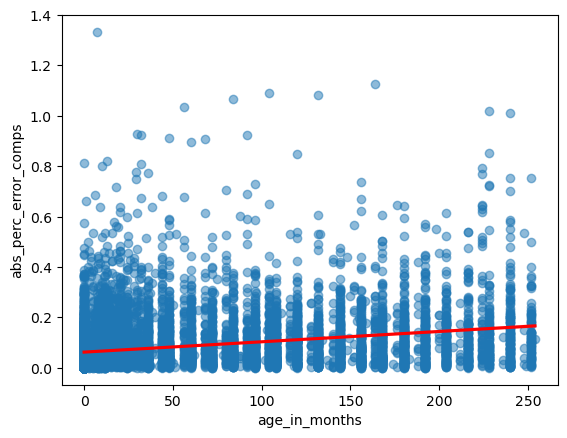

In [37]:
# see reg plot
sns.regplot(
    data=(
        gdf_properties
        .query("num_neighbors > 1")
        .sample(10_000)
    ),
    x='age_in_months',
    y='abs_perc_error_comps',
    scatter_kws={'alpha': .5},
    line_kws={'color': 'red'}
)

In [38]:
# with respect land
model = smf.ols(
    formula='abs_perc_error_comps ~ saleable_area',
    data=gdf_properties.query("num_neighbors > 1", engine='python'),
).fit()

# see summary
model.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     abs_perc_error_comps   R-squared:                       0.047
Model:                              OLS   Adj. R-squared:                  0.047
Method:                   Least Squares   F-statistic:                 9.349e+04
Date:                  Mon, 04 Nov 2024   Prob (F-statistic):               0.00
Time:                          14:15:39   Log-Likelihood:             1.6184e+06
No. Observations:               1908483   AIC:                        -3.237e+06
Df Residuals:                   1908481   BIC:                        -3.237e+06
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0542      0.000    440.602      0.000       0.054       0.054
saleable_area     0.0003   1.07e-06    305.762      0.000       0.000       0.000
==============================================================================
Omnibus:                  1488425.726   Durbin-Watson:                   1.605
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         59725489.524
Skew:                           3.426   Prob(JB):                         0.00
Kurtosis:                      29.535   Cond. No.                         189.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='saleable_area', ylabel='abs_perc_error_comps'>

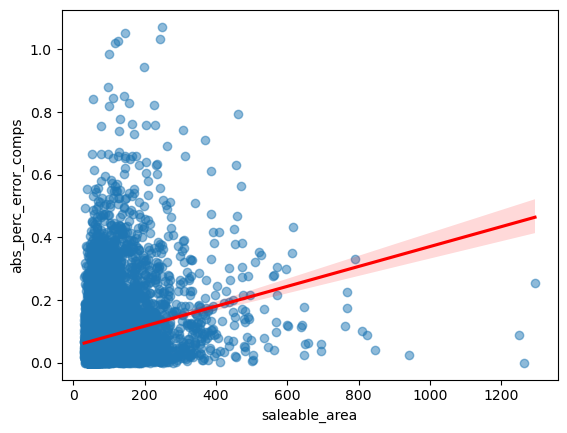

In [39]:
# see reg plot
sns.regplot(
    data=(
        gdf_properties
        .query("num_neighbors > 1")
        .sample(10_000)
    ),
    x='saleable_area',
    y='abs_perc_error_comps',
    scatter_kws={'alpha': .5},
    line_kws={'color': 'red'}
)

In [41]:
# with respect land
model = smf.ols(
    formula='abs_perc_error_comps ~ land_area',
    data=gdf_properties.query("num_neighbors > 1", engine='python'),
).fit()

# see summary
model.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     abs_perc_error_comps   R-squared:                       0.030
Model:                              OLS   Adj. R-squared:                  0.030
Method:                   Least Squares   F-statistic:                 5.852e+04
Date:                  Mon, 04 Nov 2024   Prob (F-statistic):               0.00
Time:                          14:15:52   Log-Likelihood:             1.6016e+06
No. Observations:               1908483   AIC:                        -3.203e+06
Df Residuals:                   1908481   BIC:                        -3.203e+06
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0649      0.000    592.750      0.000       0.065       0.065
land_area      0.0002   7.06e-07    241.911      0.000       0.000       0.000
==============================================================================
Omnibus:                  1494418.418   Durbin-Watson:                   1.589
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         63004689.348
Skew:                           3.429   Prob(JB):                         0.00
Kurtosis:                      30.300   Cond. No.                         224.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='land_area', ylabel='abs_perc_error_comps'>

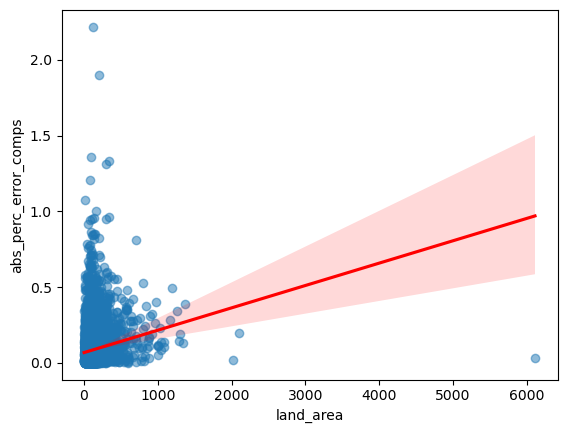

In [42]:
# see reg plot
sns.regplot(
    data=(
        gdf_properties
        .query("num_neighbors > 1")
        .sample(10_000)
    ),
    x='land_area',
    y='abs_perc_error_comps',
    scatter_kws={'alpha': .5},
    line_kws={'color': 'red'}
)

In [43]:
# with respect land
model = smf.ols(
    formula='abs_perc_error_comps ~ built_area',
    data=gdf_properties.query("num_neighbors > 1", engine='python'),
).fit()

# see summary
model.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     abs_perc_error_comps   R-squared:                       0.043
Model:                              OLS   Adj. R-squared:                  0.043
Method:                   Least Squares   F-statistic:                 8.622e+04
Date:                  Mon, 04 Nov 2024   Prob (F-statistic):               0.00
Time:                          14:15:55   Log-Likelihood:             1.6149e+06
No. Observations:               1908483   AIC:                        -3.230e+06
Df Residuals:                   1908481   BIC:                        -3.230e+06
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0530      0.000    408.339      0.000       0.053       0.053
built_area     0.0004   1.23e-06    293.640      0.000       0.000       0.000
==============================================================================
Omnibus:                  1489853.759   Durbin-Watson:                   1.604
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         59339436.482
Skew:                           3.434   Prob(JB):                         0.00
Kurtosis:                      29.440   Cond. No.                         182.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='built_area', ylabel='abs_perc_error_comps'>

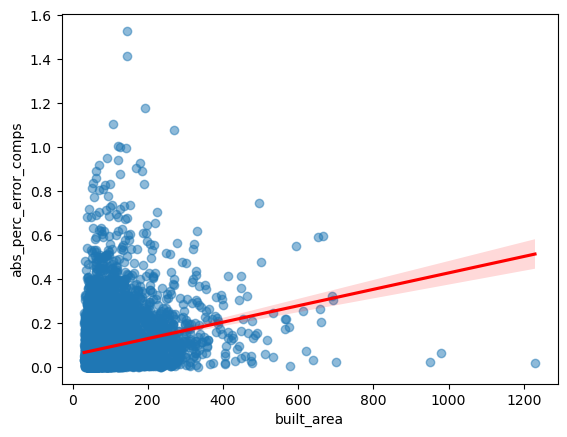

In [44]:
# see reg plot
sns.regplot(
    data=(
        gdf_properties
        .query("num_neighbors > 1")
        .sample(10_000)
    ),
    x='built_area',
    y='abs_perc_error_comps',
    scatter_kws={'alpha': .5},
    line_kws={'color': 'red'}
)

^^^ 
some problems with the saleable_area

---
# Save

In [ ]:
# estimate mode and quantile 5% and 95% of lognormal
df_comps_info = (
    df_comps_info
    .assign(
        ppsm_comps=lambda x: np.exp(x['log_ppsm_mean_comps'] - x['log_ppsm_std_comps']**2),
        ppsm_lower_comps=lambda x: lognorm.ppf(0.05, s=x['log_ppsm_std_comps'], scale=np.exp(x['log_ppsm_mean_comps'])),
        ppsm_upper_comps=lambda x: lognorm.ppf(0.95, s=x['log_ppsm_std_comps'], scale=np.exp(x['log_ppsm_mean_comps']))
    )
)

# stay only with ppsm_comps, ppsm_lower_comps, ppsm_upper_comps and num_neighbors
df_comps_info = df_comps_info.loc[:, ['observation_id_own', 'ppsm_comps', 'ppsm_lower_comps', 'ppsm_upper_comps', 'num_neighbors']]

# look
df_comps_info.head()

,observation_id_own,ppsm_comps,ppsm_lower_comps,ppsm_upper_comps,num_neighbors
0,00598e09-f435-47ea-a468-7ef45cdddc39,9175.722259,6506.897459,14598.717158,60.0
1,0077f2ba-2fa0-410d-bbc5-a11b4bee9d7a,7530.613335,5698.857643,10710.996067,60.0
2,0089142d-1c8d-48af-8552-96f575b1b9e8,9690.489283,6914.446157,15243.906573,60.0
3,00948ac3-a750-47d3-8a73-45820cdf2a1d,8172.236437,5538.462242,14207.648216,60.0
4,00ab3e6c-e7a9-4972-9626-e0508a58c7c9,9703.627848,8073.899864,12006.700579,60.0


In [60]:
# read properties
df_properties = pd.read_parquet("../../data/interim/cleaned_data_s4.parquet")

# merge
df_properties = (
    df_properties
    .merge(
        df_comps_info,
        how='inner',
        left_on='observation_id',
        right_on='observation_id_own'
    )
    .drop(columns='observation_id_own')
    .query("num_neighbors > 1")
)

# look
print(df_properties.shape)
df_properties.head()

(1908483, 57)


,half_bathrooms,full_bathrooms,property_class_more_common_in_area,neighborhood,constructor,zip_code,age_in_months,parking_lots,valuation_date,potable_water_service_id,lighting_service_id,sidewalk_id,project_quality_id,property_class_id,conservation_status_id,controller_id,elevator_service_id,state_id,equipment_id,curb_id,infrastructure_service_id,road_materials_id,municipality_id,grantor_id,urban_proximity_id,water_collection_service_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,public_transportation_service_id,valuation_unit_id,valuation_professional_id,latitude,longitude,level,total_levels,purpose_of_appraisal,bedrooms,built_area,saleable_area,land_area,rentable_units,rentable_units_subject_property,current_use,market_price,price,built_price,land_price,access_routes,remaining_useful_life,observation_id,property_id,city_cluster,ppsm_comps,ppsm_lower_comps,ppsm_upper_comps,num_neighbors
0,1,2,4,MAYA,NO APLICA,97134,204,1,2022-11-15,NaN,NaN,NaN,NaN,4,4,717559f7-a918-48f7-9356-c79c582d95b3,0.0,31,2,NaN,1,2,050,9a2781c9-b312-453c-86d1-a6e90584a083,2,NaN,NaN,NaN,2,NaN,b3bf58b2-40cc-4edd-bcf1-e4a0b2798533,02af4710-0922-4bed-9763-045ba14e0283,21.014297,-89.575189,3,2,S/D,3,141.550003,154.929993,198.000000,1.0,NaN,<NA>,2348706.0,2349000.0,1111845.21,984852.00,<NA>,53,43c375b2-75fd-4fcc-b311-55b396e7cbbf,b7f8c282-b67e-5d63-920d-c603b4e2eb52,0,14628.264263,10389.165128,23209.085607,60.0
1,0,1,3,MULCHECHEN,NO APLICA,97370,192,1,2022-11-01,NaN,NaN,NaN,NaN,3,4,8378ef1c-2fdf-4b2a-be29-0e62eb19d753,2.0,31,2,NaN,1,3,041,98013144-6a9f-4e08-9255-cb54568d2f5a,3,NaN,NaN,NaN,2,NaN,4e63856b-ae68-4653-bcaa-86a51d5d7053,923b9bb1-9ab4-4984-93f1-c873b3c26977,20.916897,-89.580945,3,1,S/D,2,52.049999,54.209999,133.750000,1.0,NaN,<NA>,424468.0,424000.0,290492.55,96835.00,<NA>,44,f95c14fe-9acc-4b5c-872b-bd15d412a65d,7215360d-9d5e-538a-971f-15fbef435f54,0,10173.151915,9156.730439,11403.414006,60.0
2,1,4,5,LOCALIDAD DE CHABLEKAL,NO APLICA,97302,120,2,2022-11-07,NaN,NaN,NaN,NaN,5,5,717559f7-a918-48f7-9356-c79c582d95b3,0.0,31,1,NaN,1,2,050,8765c4c5-2144-413d-bc01-616fdef51316,3,NaN,NaN,NaN,2,NaN,b3bf58b2-40cc-4edd-bcf1-e4a0b2798533,02af4710-0922-4bed-9763-045ba14e0283,21.097061,-89.618003,3,2,S/D,3,520.500000,674.960022,1200.000000,1.0,NaN,<NA>,17284861.0,17285000.0,8624980.00,5552400.00,<NA>,70,185761da-dc39-4835-86c5-981424f72208,ea19d861-f75b-5ca2-9bd6-177a0c0bd830,0,25737.697821,18219.727072,41082.528033,56.0
3,1,2,3,FRACCIONAMIENTO AMANECERES,NO PROPORCIONADO,97370,0,1,2022-11-16,NaN,NaN,NaN,NaN,3,6,8b6705bf-3b28-4a0c-8e1e-564dc7d09cf3,0.0,31,1,NaN,1,3,041,b6ec5872-8e1c-4a3e-908f-5dc1ab822e5b,4,NaN,NaN,NaN,2,NaN,7ffc29d8-5fe3-4c98-8570-5e5027bdd604,82a61e5f-2755-4cd2-9c60-96d1859009dd,20.961569,-89.529486,3,1,S/D,2,111.629997,111.629997,181.699997,1.0,NaN,<NA>,1183300.0,1183000.0,837225.00,199870.00,<NA>,60,4e2c4e1a-e759-48ab-a4f6-2d1dbc6f55da,d71ff72e-16ad-5c47-be4b-7c6faf2e9225,0,11062.325787,9922.074419,12451.729776,60.0
4,0,2,4,MERIDA,NO APLICA,97206,240,1,2022-11-23,NaN,NaN,NaN,NaN,4,4,717559f7-a918-48f7-9356-c79c582d95b3,0.0,31,2,NaN,1,2,050,b6ec5872-8e1c-4a3e-908f-5dc1ab822e5b,2,NaN,NaN,NaN,2,NaN,b3bf58b2-40cc-4edd-bcf1-e4a0b2798533,02af4710-0922-4bed-9763-045ba14e0283,21.015836,-89.654367,3,1,S/D,3,103.570000,138.380005,364.000000,1.0,NaN,<NA>,1878072.0,1878000.0,762310.40,948518.48,<NA>,50,d51a3c97-180f-453a-8364-800116e0bfd6,5b145754-3253-589b-8de7-cab1f74fdde3,0,10613.599657,7070.157571,19137.024596,60.0


In [61]:
# save
df_properties.to_parquet("../../data/interim/cleaned_data_s5.parquet")

---
# Sandbox

In [40]:
# cols
gdf_properties.columns.to_list()

['observation_id',
 'neighborhood',
 'state_id',
 'municipality_id',
 'city_cluster',
 'latitude',
 'longitude',
 'market_price',
 'price',
 'saleable_area',
 'built_area',
 'land_area',
 'property_class_id',
 'property_type_id',
 'age_in_months',
 'ppsm',
 'geometry',
 'log_ppsm_mean_comps',
 'log_ppsm_std_comps',
 'num_neighbors',
 'mean_comps_ppsm',
 'median_comps_ppsm',
 'mode_comps_ppsm',
 'mape_mean',
 'mape_median',
 'mape_mode',
 'perc_error_comps',
 'abs_perc_error_comps']